# Calculating Northern Hemisphere Sea Ice Metrics

This notebook describes how to calculate northern hemisphere sea ice extent and sea ice area from monthly grids of sea ice concentration.

Northern hemisphere sea ice extent is the total area for each timestep of northern hemisphere grid cells with greater than 15% sea ice concentration.  Northern hemisphere sea ice area is the sum for each timestep of the products of fractional sea ice concentration and grid cell area.  I follow the ESGF and CMIP naming conventions and call northern hemipshere sea ice extent `siextentn` and nothern hemipshere sea ice area `siarean`.
$$
sixetentn = \sum{\alpha \times siconc \times areacello}; \alpha = \left\{ 
                                                              \begin{array}{11}
                                                              1; siconc \geq 0.15\\
                                                              0; siconc < 0.15
                                                              \end{array}
                                                              \right.
$$
$$
siarean = \sum{siconc \times areacello}
$$

Two files are required each model; a `siconc` file and an `areacello` file.  `areacello` is the area in $m^2$ for ocean grid cells.  The appropriate grid cell area variable for `siconc` is given in the `cell_measures` attribute for `siconc`.  This can be checked on a Linux machine by "grepping" for the `cell_measures` line in the netcdf header using `ncdump -h`

In [1]:
%%bash
for f in `ls /home/apbarret/Data/CMIP6/siconc/SImon/*/historical/r1i1p1f1/siconc_SImon_*_historical_r1i1p1f1_gn_185001-*.nc`; 
do 
result=`ncdump -h $f | grep "cell_measures"`; 
echo "$(basename -- $f) $result"; 
done

siconc_SImon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc 		siconc:cell_measures = "area: areacello" ;
siconc_SImon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc 		siconc:cell_measures = "area: areacello" ;
siconc_SImon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-185012.nc 		siconc:cell_measures = "area: areacello" ;
siconc_SImon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc 		siconc:cell_measures = "area: areacello" ;
siconc_SImon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc 		siconc:cell_measures = "area: areacello" ;
siconc_SImon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc 		siconc:cell_measures = "area: areacello" ;
siconc_SImon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc 		siconc:cell_measures = "area: areacello" ;
siconc_SImon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc 		siconc:cell_measures = "area: areacello" ;
siconc_SImon_CESM2-FV2_historical_r1i1p1f1_gn_185001-189912.nc 		siconc:cell_measures = "area: areacello" ;
siconc_SImon_CES

Frustratingly, models do not have a consistent naming convention for dimensions.  Some modelling groups have used `x` and `y` for grid dimensions and some have used `i` and `j`.  Latitude and longitude coordinates can be `lat` and `lon` or `latitude` and `longitude`.  In some cases, dimension names are not consistent between `siconc` and `areacello` files.  So dimension names in one of the files have to be renamed to so that dimensions names match. 

In [2]:
import os
import glob
import datetime as dt

import matplotlib.pyplot as plt

import xarray as xr
import pandas as pd

In [3]:
DATA_PATH = "/home/apbarret/Data/CMIP6"
SICONC_PATH = os.path.join(DATA_PATH, "siconc", "SImon")
AREACELLO_PATH = os.path.join(DATA_PATH, "areacello")

## Matching models with `areacello`

In [4]:
model_list = [os.path.basename(p) for p in glob.glob(os.path.join(SICONC_PATH, '*'))]
model_list

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-ESM-1-1-LR',
 'BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CanESM5',
 'CAS-ESM2-0',
 'CESM2',
 'CESM2-FV2',
 'CESM2-WACCM',
 'CESM2-WACCM-FV2',
 'CIESM',
 'CMCC-CM2-HR4',
 'CMCC-CM2-SR5',
 'EC-Earth3-Veg',
 'EC-Earth3-Veg-LR',
 'FGOALS-f3-L',
 'FGOALS-g3',
 'FIO-ESM-2-0',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorCPM1',
 'NorESM2-LM',
 'NorESM2-MM',
 'SAM0-UNICON',
 'TaiESM1']

In [5]:
model = "CESM2"
experiment = "historical"
ensemble = "r1i1p1f1"

EXCLUDE_THESE_MODELS = ['CESM2-WACCM']

## Get the data

In [6]:
def find_siconc_files(model, experiment, ensemble):
    files = glob.glob(os.path.join(SICONC_PATH, model, experiment, ensemble, "*.nc"))
    if not files:
        raise Exception(f"No siconc files found for {model} {experiment} {ensemble}")
    return files


def get_siconc(filepaths):
    '''Returns xarray.Dataset for a given model run'''
    ds = xr.open_mfdataset(filepaths, combine="by_coords", use_cftime=True)
    #ds['time'] = ds.indexes['time'].to_datetimeindex()
    if 'lat' in ds.variables:
        ds = ds.rename({'lat': 'latitude', 'lon': 'longitude'})
    if 'ni' in ds.dims:
        ds = ds.rename_dims({'ni': 'i', 'nj': 'j'})
    if 'ni' in ds.variables:
        ds = ds.rename({'ni': 'i', 'nj': 'j'})
    if 'nav_lat' in ds.variables:
        ds = ds.rename({'nav_lat': 'latitude', 'nav_lon': 'longitude'})
    if 'x' in ds.variables:
        ds = ds.rename({'x': 'i', 'y': 'j'})
    if 'x' in ds.dims:
        ds = ds.rename({'x': 'i', 'y': 'j'})
    ds['siconc'] = ds.siconc * 1e-2
    return ds


def find_areacello_file(model):
    files = glob.glob(os.path.join(AREACELLO_PATH, f"areacello_*_{model}_*.nc"))
    if not files:
        raise Exception(f"No areacello file for {model}")
    return files[0]


def get_areacello(filepath, verbose=False):
    '''Returns xarray.Dataset containing ocean gridcell area'''
    if verbose: print(f"Getting ocean cell area from {area_file}")
    ds = xr.open_dataset(filepath, use_cftime=True)
    if 'nlat' in ds.variables:
        ds = ds.rename({'nlat': 'j', 'nlon': 'i'})  # rename nlat and nlon dimensions to match siconc
    if 'nav_lat' in ds.variables:
        ds = ds.rename({'nav_lat': 'latitude', 'nav_lon': 'longitude'})
    if 'lat' in ds.variables:
        ds = ds.rename({'lat': 'latitude', 'lon': 'longitude'})
    if 'x' in ds.variables:
        ds = ds.rename({'x': 'i', 'y': 'j'})
    if 'x' in ds.dims:
        ds = ds.rename({'x': 'i', 'y': 'j'})
    if any([substr in filepath for substr in ['FGOALS-f3-L', 'FGOALS-g3']]):
        ds['j'] = list(reversed(ds.indexes['j']))
    ds['areacello'] = ds.areacello * 1e-6  # convert from m^2 to km^2
    return ds


def calc_siarean(siconc, area):
    siarea = siconc.siconc.where(siconc.siconc > 0.) * area.areacello
    return siarea.where(area.latitude > 0.).sum(dim=['j', 'i'])


def calc_siextentn(siconc, area):
    siextent = siconc.siconc.where(siconc.siconc > .15) * area.areacello
    return siextent.where(area.latitude > 0.).sum(dim=['j', 'i'])


def load_data(model):
    '''Loads siconc and area data as xarray.Datasets'''
    try:
        siconc_files = find_siconc_files(model, experiment, ensemble)
    except Exception as error:
        raise Exception(error)
    
    try:
        areacello_file = find_areacello_file(model)
    except Exception as error:
        raise Exception(error)
        
    siconc_ds = get_siconc(siconc_files)
    area_ds = get_areacello(areacello_file)

    assert set(area_ds.areacello.dims).issubset(set(siconc_ds.siconc.dims)), f"{area_ds.areacello.dims} is not subset of {siconc_ds.siconc.dims} for {model}"
    assert 'latitude' in area_ds.variables and 'longitude' in area_ds.variables, f"latitude and longitude are not variables in areacello Dataset of {model}"
    assert 'latitude' in siconc_ds.variables and 'longitude' in siconc_ds.variables, f"latitude and longitude are not variables in siconc Dataset of {model}"
    assert 'i' in area_ds.areacello.dims and 'j' in area_ds.areacello.dims, f"Expect dimensions ('i', 'j') for areacello for {model}, found {area_ds.areacello.dims} instead"
    assert 'i' in siconc_ds.siconc.dims and 'j' in siconc_ds.siconc.dims, f"Expect dimensions ('i', 'j') for siconc for {model}, found {siconc_ds.areacello.dims} instead"

    return siconc_ds, area_ds

In [7]:
siarean_dct = {}
siextentn_dct = {}
for model in model_list:
    
    print(model)
    
    if model in EXCLUDE_THESE_MODELS:
        continue
    
    try:
        siconc_ds, area_ds = load_data(model)
    except Exception as error:
        print(error)
        print("Skipping...\n")
        continue

    #siarean = calc_siarean(siconc_ds, area_ds)
    #siarean['time'] = [dt.datetime(t.year, t.month, 1) for t in siarean.time.values]
    #siarean_dct[model] = siarean.to_series()
    
    siextentn = calc_siextentn(siconc_ds, area_ds)
    siextentn['time'] = [dt.datetime(t.year, t.month, 1) for t in siextentn.time.values]
    siextentn_dct[model] = siextentn.to_series()
    
    siconc_ds.close()
    area_ds.close()

#siarean_df = pd.DataFrame(siarean_dct)
siextentn_df = pd.DataFrame(siextentn_dct)

ACCESS-CM2
ACCESS-ESM1-5
AWI-ESM-1-1-LR
No areacello file for AWI-ESM-1-1-LR
Skipping...

BCC-CSM2-MR
No areacello file for BCC-CSM2-MR
Skipping...

BCC-ESM1
No areacello file for BCC-ESM1
Skipping...

CAMS-CSM1-0
No areacello file for CAMS-CSM1-0
Skipping...

CanESM5
CAS-ESM2-0
No areacello file for CAS-ESM2-0
Skipping...

CESM2


/home/apbarret/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'siconc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/home/apbarret/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


CESM2-FV2


/home/apbarret/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'siconc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/home/apbarret/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


CESM2-WACCM
CESM2-WACCM-FV2


/home/apbarret/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'siconc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/home/apbarret/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


CIESM
CMCC-CM2-HR4
CMCC-CM2-SR5
EC-Earth3-Veg
EC-Earth3-Veg-LR
FGOALS-f3-L
FGOALS-g3
FIO-ESM-2-0
No areacello file for FIO-ESM-2-0
Skipping...

IPSL-CM6A-LR
MIROC6
MPI-ESM-1-2-HAM
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NESM3
No areacello file for NESM3
Skipping...

NorCPM1
NorESM2-LM
NorESM2-MM
SAM0-UNICON
TaiESM1
No areacello file for TaiESM1
Skipping...



In [8]:
siextentn_df

,ACCESS-CM2,ACCESS-ESM1-5,CanESM5,CESM2,CESM2-FV2,CESM2-WACCM-FV2,CIESM,CMCC-CM2-HR4,CMCC-CM2-SR5,EC-Earth3-Veg,...,IPSL-CM6A-LR,MIROC6,MPI-ESM-1-2-HAM,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NorCPM1,NorESM2-LM,NorESM2-MM,SAM0-UNICON
time,,,,,,,,,,,,,,,,,,,,,
1850-01-01,14308180.0,13390206.00,14487656.0,13509826.00,13721056.00,14181558.00,1.167091e+07,12871690.00,1.207155e+07,18107524.0,...,15325478.00,11340508.00,13066469.00,13719473.00,14398823.00,13804455.00,14029387.0,14099591.00,14148131.0,14752154.0
1850-02-01,15219563.0,14648249.00,15624129.0,14296586.00,14169093.00,14683432.00,1.314105e+07,13462232.00,1.296224e+07,19181528.0,...,16732327.00,11804319.00,13794389.00,13982570.00,15373475.00,14883037.00,14407098.0,14428173.00,14753364.0,15443718.0
1850-03-01,15770274.0,15063934.00,15795635.0,14682684.00,14575154.00,14613186.00,1.318602e+07,13497665.00,1.299229e+07,19811950.0,...,16612977.00,12018005.00,14039296.00,14422840.00,15646894.00,15115587.00,14686785.0,14314548.00,14805147.0,15685420.0
1850-04-01,15158420.0,14462346.00,15030034.0,14195283.00,14241801.00,14476560.00,1.288926e+07,12668195.00,1.219292e+07,18880524.0,...,15600221.00,11775305.00,13370304.00,13818382.00,14574862.00,14215509.00,14245536.0,13895150.00,14015628.0,14841992.0
1850-05-01,13450775.0,12848966.00,13342696.0,12629368.00,12793143.00,13047240.00,1.121389e+07,10800211.00,1.030456e+07,16729766.0,...,12965280.00,10656796.00,12055992.00,12376026.00,12421906.00,12428150.00,12774972.0,12263137.00,12435896.0,13200796.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-01,4283490.5,4332546.00,4329827.5,2497407.50,4188402.25,3466805.00,3.375055e+02,3740170.25,1.876843e+04,4729294.5,...,4284709.00,3806945.25,4024989.25,3214775.25,3570186.00,2667368.75,8085232.0,3709442.25,5839159.0,5310436.0
2014-09-01,4175908.0,3521887.25,4038665.5,1795707.25,3215760.00,2556551.25,0.000000e+00,3867330.25,1.747920e+03,5393816.0,...,3699060.75,3630372.00,3958114.00,2969214.75,3338078.75,1782798.50,8687322.0,3328324.75,5845406.5,4547687.0
2014-10-01,6243778.5,4894603.00,6354000.0,4785479.50,5138790.00,5479487.00,5.870449e+04,5802829.50,4.496262e+04,7597376.5,...,5014123.00,5350778.00,5549619.50,4684597.50,4730908.50,3425069.25,9780477.0,6207281.00,7882022.0,6674611.0


In [10]:
siextentn_df.to_csv('cmip6_siextentn_historical_r1i1p1f1.from_siconc.csv')

<AxesSubplot:xlabel='time'>

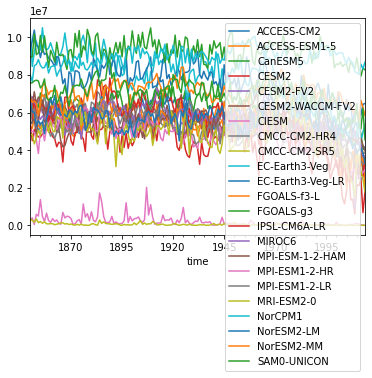

In [9]:
siextentn_df[siextentn_df.index.month == 9].plot()

In [ ]:
id=22
model = 'CIESM'
fig, ax = plt.subplots(figsize=(15,5))
siarean_df[siarean_df.index.month == 9].loc[:,model].plot(title=model, ylim=(0,10e6))

In [ ]:
model='CESM2'
siconc_file = find_siconc_files(model, experiment, ensemble)
areacello_file = find_areacello_file(model)

#data = xr.open_mfdataset(siconc_file, combine='by_coords')
#area = xr.open_dataset(areacello_file)
data = get_siconc(siconc_file)
area = get_areacello(areacello_file)

siarean = calc_siarean(data, area)
siarean['time'] = [dt.datetime(t.year, t.month, 1) for t in siarean.time.values]


ts = siarean.to_series()

ts[ts.index.month == 9].plot()

In [ ]:
area.areacello.max()

In [ ]:
area

In [ ]:
area['j'] = list(reversed(area.indexes['j']))

In [ ]:
model='CESM2'
siconc_file = find_siconc_files(model, experiment, ensemble)
print(siconc_file)
cesm2 = get_siconc(siconc_file)
cesm2.siconc.max().values

In [ ]:
model='CIESM'
siconc_file = find_siconc_files(model, experiment, ensemble)
print(siconc_file)
ciesm = get_siconc(siconc_file)
ciesm.siconc.max().values

In [ ]:
diff = cesm2.siconc.isel(time=1779) - ciesm.siconc.isel(time=1779)

In [ ]:
diff

In [ ]:
diff.plot()

In [ ]:
ds

In [ ]:
ds.siconc.max().values